In [1]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Carregando os dados
df = pd.read_csv(r"C:\Users\kevel\OneDrive\Área de Trabalho\Data Scyentist\PROJETO DE DS\ENEM 2021\DADOS\MICRODADOS_ENEM_2021.csv", sep=";", encoding='latin1')

Valores ausentes por coluna:
TP_ENSINO                 2293004
CO_MUNICIPIO_ESC          2576026
NO_MUNICIPIO_ESC          2576026
CO_UF_ESC                 2576026
SG_UF_ESC                 2576026
TP_DEPENDENCIA_ADM_ESC    2576026
TP_LOCALIZACAO_ESC        2576026
TP_SIT_FUNC_ESC           2576026
CO_PROVA_CN               1143988
CO_PROVA_CH               1011453
CO_PROVA_LC               1011453
CO_PROVA_MT               1143988
NU_NOTA_CN                1144381
NU_NOTA_CH                1016085
NU_NOTA_LC                1013701
NU_NOTA_MT                1144441
TX_RESPOSTAS_CN           1143988
TX_RESPOSTAS_CH           1011453
TX_RESPOSTAS_LC           1011453
TX_RESPOSTAS_MT           1143988
TX_GABARITO_CN            1143988
TX_GABARITO_CH            1011453
TX_GABARITO_LC            1011453
TX_GABARITO_MT            1143988
TP_STATUS_REDACAO         1011453
NU_NOTA_COMP1             1011453
NU_NOTA_COMP2             1011453
NU_NOTA_COMP3             1011453
NU_NOTA_COMP4      

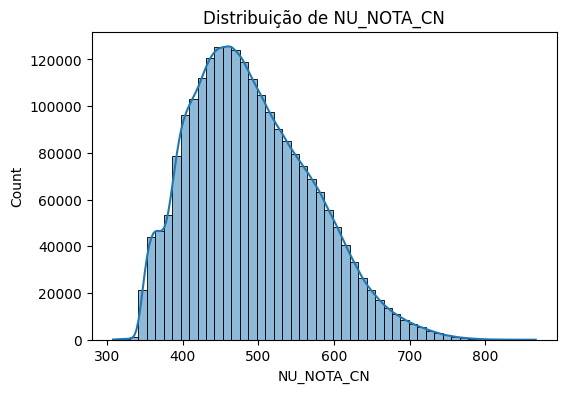

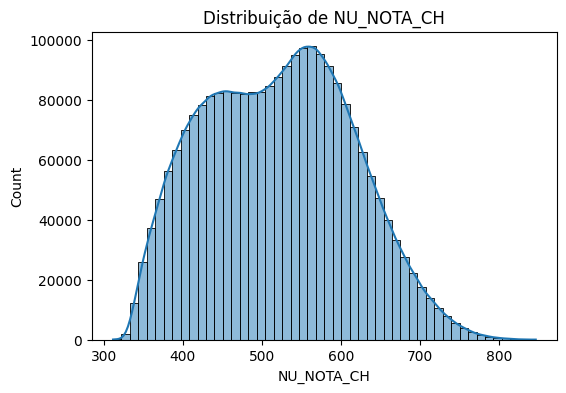

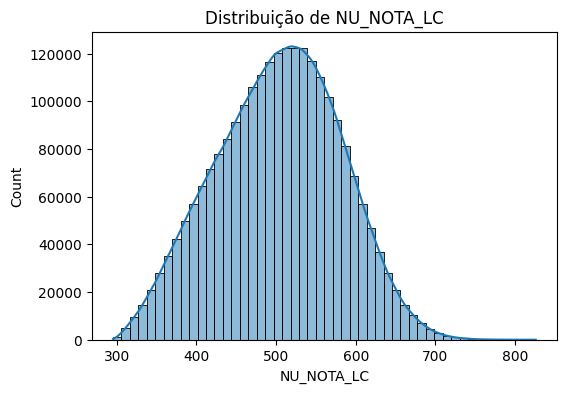

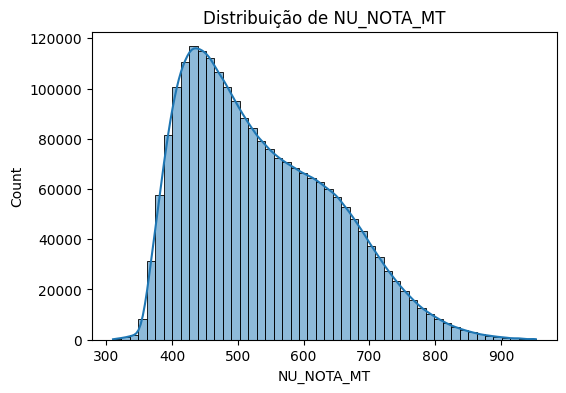

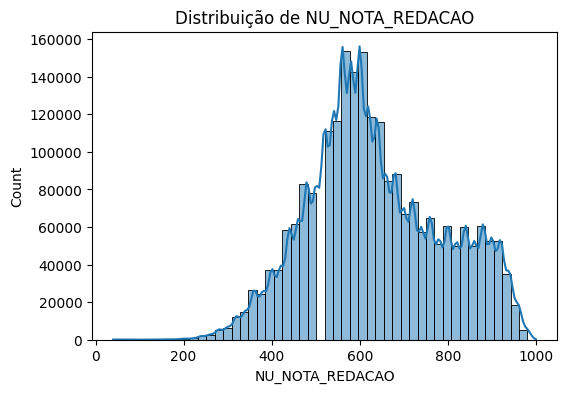

NU_NOTA_CN         1144381
NU_NOTA_CH         1016085
NU_NOTA_LC         1013701
NU_NOTA_MT         1144441
NU_NOTA_REDACAO    1096035
dtype: int64


In [5]:
# Analisando valores ausentes
missing_values = df.isnull().sum()
print("Valores ausentes por coluna:")
print(missing_values[missing_values > 0])

# Identificando possíveis dados ausentes representados por zeros nas notas
cols_notas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
for col in cols_notas:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f"Distribuição de {col}")
    plt.show()

# Substituindo zeros nas notas por NaN para indicar ausência
df[cols_notas] = df[cols_notas].replace(0, np.nan)
print(df[cols_notas].isnull().sum())

Assimetria de NU_NOTA_CN: 0.5135234303066112
Assimetria de NU_NOTA_CH: 0.13605520259364506
Assimetria de NU_NOTA_LC: -0.06707688695936152
Assimetria de NU_NOTA_MT: 0.6043973780780232
Assimetria de NU_NOTA_REDACAO: 0.2065119475988691


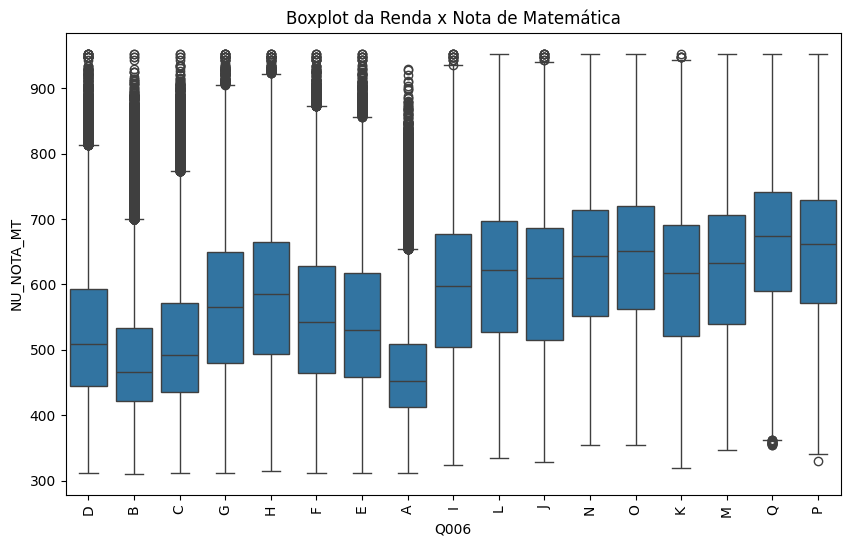

In [6]:
# Tratamento de outliers e assimetria
for col in cols_notas:
    skewness = df[col].skew()
    print(f"Assimetria de {col}: {skewness}")
    if skewness > 1:  # Se for altamente assimétrico, considerar transformação log
        df[f"log_{col}"] = np.log1p(df[col])

# Boxplot da relação entre renda e nota de matemática
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Q006'], y=df['NU_NOTA_MT'])
plt.xticks(rotation=90)
plt.title("Boxplot da Renda x Nota de Matemática")
plt.show()

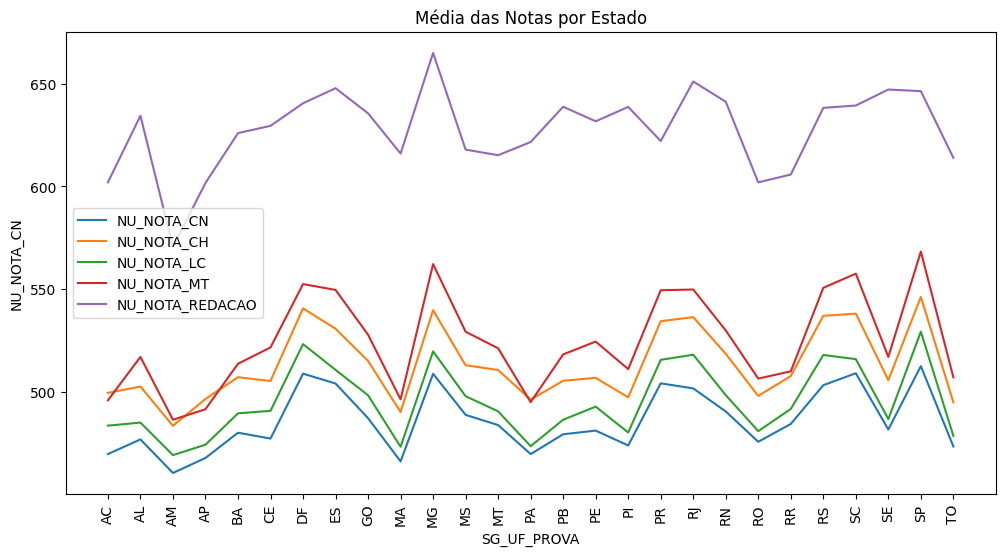

In [7]:
# Média das notas por estado
df_grouped = df.groupby('SG_UF_PROVA')[cols_notas].mean().reset_index()
plt.figure(figsize=(12, 6))
for col in cols_notas:
    sns.lineplot(x='SG_UF_PROVA', y=col, data=df_grouped, label=col)

plt.xticks(rotation=90)
plt.legend()
plt.title("Média das Notas por Estado")
plt.show()


In [8]:
# Criando a variável de abstenção (1 para ausente, 0 para presente)
df['abstencao'] = df['TP_PRESENCA_MT'].apply(lambda x: 1 if x == 0 else 0)

# Selecionando colunas relevantes para prever abstenção
cols_relevantes = ['SG_UF_PROVA', 'Q006', 'TP_ESCOLA', 'TP_DEPENDENCIA_ADM_ESC',
                   'TP_COR_RACA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_FAIXA_ETARIA']
df_model = df[cols_relevantes + ['abstencao']].dropna()

In [9]:

# Convertendo variáveis categóricas em numéricas
df_model = pd.get_dummies(df_model, columns=['SG_UF_PROVA', 'Q006', 'TP_ESCOLA', 'TP_DEPENDENCIA_ADM_ESC',
                                             'TP_COR_RACA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_FAIXA_ETARIA'],
                          drop_first=True)

# Separando dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(df_model.drop(columns=['abstencao']), df_model['abstencao'],
                                                    test_size=0.2, random_state=42)

# Treinando modelo RandomForest para prever abstenção
model_abstencao = RandomForestClassifier(n_estimators=100, random_state=42)
model_abstencao.fit(X_train, y_train)
y_pred = model_abstencao.predict(X_test)

# Avaliação do modelo de abstenção
print("Acurácia do modelo de abstenção:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))




Acurácia do modelo de abstenção: 0.775033484474263
              precision    recall  f1-score   support

           0       0.79      0.94      0.86    120984
           1       0.63      0.30      0.40     41778

    accuracy                           0.78    162762
   macro avg       0.71      0.62      0.63    162762
weighted avg       0.75      0.78      0.74    162762



In [10]:
#Prevendo notas com base em variáveis socioeconômicas
df_notas = df[cols_relevantes + cols_notas].dropna()
df_notas = pd.get_dummies(df_notas, columns=['SG_UF_PROVA', 'Q006', 'TP_ESCOLA', 'TP_DEPENDENCIA_ADM_ESC',
                                             'TP_COR_RACA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_FAIXA_ETARIA'],
                          drop_first=True)

# Separando dados de treino e teste
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(df_notas.drop(columns=cols_notas),
                                                             df_notas[cols_notas], test_size=0.2, random_state=42)

# Treinando modelo RandomForest para prever notas
model_notas = RandomForestRegressor(n_estimators=100, random_state=42)
model_notas.fit(X_train_n, y_train_n)
y_pred_n = model_notas.predict(X_test_n)

# Avaliação do modelo de notas
for i, col in enumerate(cols_notas):
    print(f"Avaliação do modelo para {col}:")
    print("MAE:", mean_absolute_error(y_test_n[col], y_pred_n[:, i]))
    print("MSE:", mean_squared_error(y_test_n[col], y_pred_n[:, i]))
    print("R²:", r2_score(y_test_n[col], y_pred_n[:, i]))
    print("-" * 50)

Avaliação do modelo para NU_NOTA_CN:
MAE: 55.945242616366876
MSE: 4854.058642214767
R²: 0.2549579891033472
--------------------------------------------------
Avaliação do modelo para NU_NOTA_CH:
MAE: 65.99462215361903
MSE: 6628.612699808981
R²: 0.1981358416380088
--------------------------------------------------
Avaliação do modelo para NU_NOTA_LC:
MAE: 52.80695736910463
MSE: 4351.148019392763
R²: 0.23610773814065045
--------------------------------------------------
Avaliação do modelo para NU_NOTA_MT:
MAE: 75.30159305801126
MSE: 8782.2179004757
R²: 0.30168955836691613
--------------------------------------------------
Avaliação do modelo para NU_NOTA_REDACAO:
MAE: 107.60410814082904
MSE: 18308.472206283695
R²: 0.24718633758060182
--------------------------------------------------
